In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import pingouin as pg

/Users/shushuzhang/anaconda3/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# 1 dim

In [16]:
data = pd.read_csv("results_1d_final.csv")
data = data[data["n"]==10000]
# kNN
data_group = data.drop(columns=["seed","p","tau","time"]).groupby(["n","Method","K"])
bias = data_group.mean().reset_index()
#bias = bias[bias["K"]==320]
std = data_group.std().reset_index()
#std = std[std["K"]==320]
RMSE = np.sqrt(data_group.apply(lambda x: (x**2).mean())).reset_index()
#RMSE = RMSE[RMSE["K"]==320]
data_group_other = data[np.isnan(data["K"])].drop(columns=["seed","p","tau","K","time"]).groupby(["n","Method"])
bias_other = data_group_other.mean().reset_index()
std_other = data_group_other.std().reset_index()
RMSE_other = np.sqrt(data_group_other.apply(lambda x: (x**2).mean())).reset_index()

In [17]:
K = 921
bias_irock = bias[((bias["Method"]=="mRock_kNN_global_linear_Neyman") | (bias["Method"]=="mRock_kNN_bs_Neyman"))  & (bias["K"]==K)]\
.drop(columns="K")#.set_index(['n','Method'])
bias_2step = bias_other[bias_other["Method"]=="two_step_Neyman"]
# bias_2step["Method"]="two-step"
bias_wide = pd.concat([bias_irock,bias_2step])
# bias_wide = bias_wide.reset_index()
replacements={"mRock_kNN_global_linear_Neyman":"i-Rock w. linear quantile",
                      "mRock_kNN_bs_Neyman":"i-Rock w. B-spline quantile",
                      "two_step_Neyman":"two-step"}
bias_wide["Method"] = bias_wide["Method"].replace(replacements)
bias_long = pd.melt(bias_wide.drop(columns='n'), id_vars=['Method'])
std_irock = std[((std["Method"]=="mRock_kNN_global_linear_Neyman") |(std["Method"]=="mRock_kNN_bs_Neyman")) & (std["K"]==K)]\
.drop(columns="K")#.set_index(['n','Method'])
std_2step = std_other[std_other["Method"]=="two_step_Neyman"]
std_wide = pd.concat([std_irock,std_2step])
std_wide["Method"] = std_wide["Method"].replace(replacements)
std_long = pd.melt(std_wide.drop(columns='n'), id_vars=['Method'])
bias_std = bias_long
bias_std["value"] = bias_long["value"]/std_long["value"]
replacements={"beta0":r"$\beta_0$",
             "beta1":r"$\beta_1$"}
bias_std["variable"] = bias_std["variable"].replace(replacements)
RMSE_irock = RMSE[((RMSE["Method"]=="mRock_kNN_global_linear_Neyman") | (RMSE["Method"]=="mRock_kNN_bs_Neyman")) & \
     (RMSE["K"]==K)].drop(columns="K")
RMSE_2step = RMSE_other[(RMSE_other["Method"]=="two_step_Neyman")].drop(columns=["Method","n"]).reset_index(drop=True)
RMSE_gl = RMSE_2step/RMSE_irock[RMSE_irock["Method"]=="mRock_kNN_global_linear_Neyman"].drop(columns=["Method","n"]).reset_index(drop=True)
RMSE_gl["Method"]="i-Rock w. linear quantile"
#RMSE_gl.reset_index(inplace=True)
RMSE_lc = RMSE_2step/RMSE_irock[RMSE_irock["Method"]=="mRock_kNN_bs_Neyman"].drop(columns=["Method","n"]).reset_index(drop=True)
RMSE_lc["Method"]="i-Rock w. B-spline quantile"
#RMSE_lc.reset_index(inplace=True)
RMSE_wide = pd.concat([RMSE_gl,RMSE_lc])
RMSE_long = pd.melt(RMSE_wide, id_vars=['Method'])
replacements={"beta0":r"$\beta_0$",
             "beta1":r"$\beta_1$"}
RMSE_long["variable"] = RMSE_long["variable"].replace(replacements)

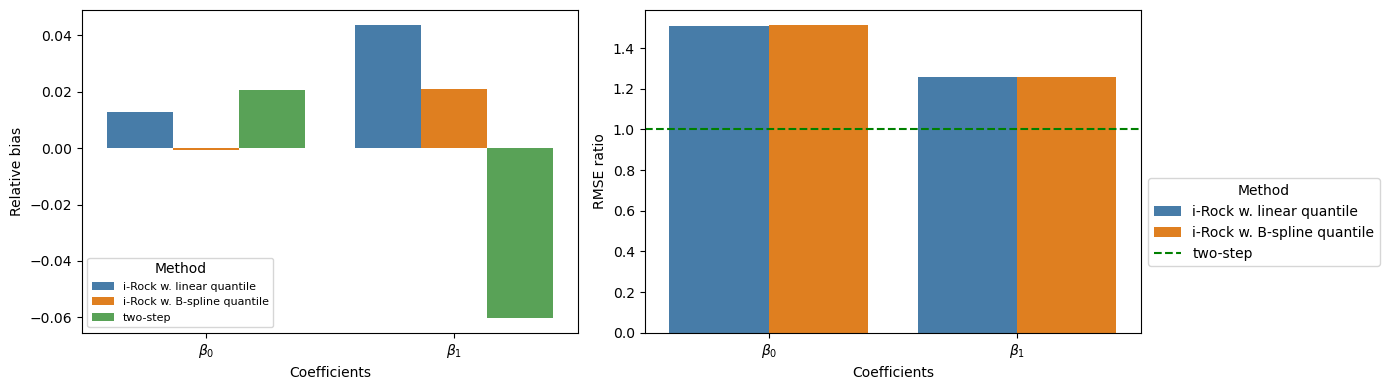

In [18]:
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1,2,1)
custom_colors = {
    'i-Rock w. linear quantile': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),   
    'i-Rock w. B-spline quantile': (1.0, 0.4980392156862745, 0.0),  
    'two-step': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726) 
}
hue_order = ['i-Rock w. linear quantile', 'i-Rock w. B-spline quantile', 'two-step']
sns.barplot(data=bias_long, x='variable', y='value', hue='Method', palette=custom_colors,hue_order = hue_order)
# Add labels and a legend
plt.xlabel('Coefficients')
plt.ylabel('Relative bias')
plt.legend(title='Method',loc="lower left",fontsize=8)
ax = fig.add_subplot(1,2,2)
custom_colors = {
    'i-Rock w. linear quantile': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),   
    'i-Rock w. B-spline quantile': (1.0, 0.4980392156862745, 0.0)
}

sns.barplot(data=RMSE_long, x='variable', y='value', palette=custom_colors, hue='Method')
ax.axhline(y=1, color='green', linestyle='--',label='two-step')
# Add labels and a legend
plt.xlabel('Coefficients')
plt.ylabel('RMSE ratio')
#plt.legend(title='Method',bbox_to_anchor = (1, 0.5))
handles, labels = ax.get_legend_handles_labels()
new_order = [1, 2, 0]  # Assuming 'two-step' is the second entry
ax.legend([handles[i] for i in new_order], [labels[i] for i in new_order], title='Method', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.savefig("1dim_bias_std_final.pdf", format="pdf")

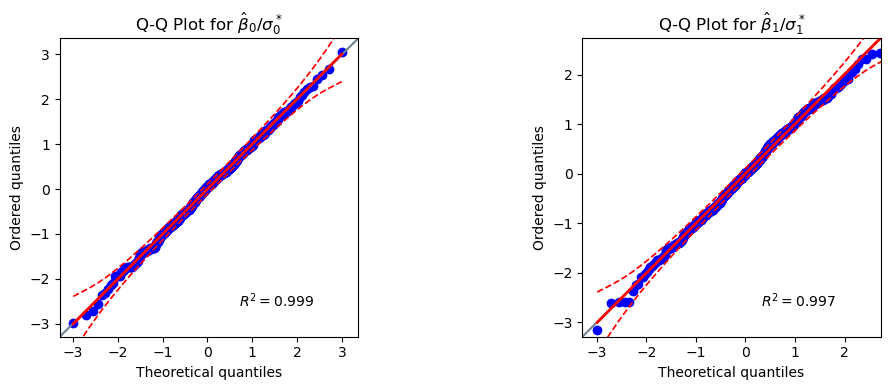

In [20]:
n = 10000
data_global = data[(data["Method"]=="mRock_kNN_bs_Neyman") & (data["K"]==921)]
#data_global = data_global[data_global["seed"]<501]
beta0 = data_global["beta0"]/np.sqrt(0.6518101/n)
# test = data_global["beta0"]/np.std(data_global["beta0"])
beta1 = data_global["beta1"]/np.sqrt(0.4794668/n)
# get the figure object
fig = plt.figure(figsize=(11, 4))

# first subplot
ax1 = fig.add_subplot(1,2,1)
ax1 = pg.qqplot(beta0, dist='norm', confidence=.95)
#sm.qqplot(beta0, line='45', ax=ax1)
ax1.set_title(r'Q-Q Plot for $\hat \beta_0/\sigma_0^*$')

# second subplot
ax2 = fig.add_subplot(1,2,2)
ax2 = pg.qqplot(beta1, dist='norm', confidence=.95)
#sm.qqplot(beta1, line='45', ax=ax2)
ax2.set_title(r'Q-Q Plot for $\hat \beta_1/\sigma_1^*$')

# show the plot
plt.tight_layout()
plt.savefig("1dim_qqplot.pdf", format="pdf")

In [15]:
# bs n=10000, K=921
loc, scale = 0, 1
#loc, scale = np.mean(beta0), np.std(beta0, ddof=1)
cdf = stats.norm(loc, scale).cdf
print(stats.ks_1samp(beta0, cdf))
print(stats.ks_1samp(beta1, cdf))

KstestResult(statistic=0.036719580277887964, pvalue=0.4986770950463246, statistic_location=-1.370403950969159, statistic_sign=1)
KstestResult(statistic=0.047698637556873424, pvalue=0.19890233824201253, statistic_location=0.6362665168174948, statistic_sign=-1)


# 3 dim nonlinear

In [46]:
data = pd.read_csv("results_3d_nl_final.csv")
#data = data[data["n"]==10000]
K = 602
# kNN
data_group = data.drop(columns=["seed","p","tau","time"]).groupby(["n","Method","K"])
bias = data_group.mean().reset_index()
bias = bias[bias["K"]==K]
std = data_group.std().reset_index()
std = std[std["K"]==K]
RMSE = np.sqrt(data_group.apply(lambda x: (x**2).mean())).reset_index()
RMSE = RMSE[RMSE["K"]==K]
data_group_other = data[np.isnan(data["K"])].drop(columns=["seed","p","tau","K","time"]).groupby(["n","Method"])
bias_other = data_group_other.mean().reset_index()
std_other = data_group_other.std().reset_index()
RMSE_other = np.sqrt(data_group_other.apply(lambda x: (x**2).mean())).reset_index()

In [47]:
methods_to_filter = ["mRock_kNN_global_linear_Neyman","mRock_kNN_global_bs_Neyman"]
bias_irock = bias[(bias["Method"].isin(methods_to_filter))].drop(columns="K")#.set_index(['n','Method'])
bias_2step = bias_other[bias_other["Method"]=="two_step_Neyman"]
# bias_2step["Method"]="two-step"
bias_wide = pd.concat([bias_irock,bias_2step])
# bias_wide = bias_wide.reset_index()
replacements={"mRock_kNN_global_linear_Neyman":"i-Rock w. linear quantile",
    "mRock_kNN_global_bs_Neyman":"i-Rock w. B-spline quantile",
                      #"local_adjust":"i-Rock w. local linear quantile (adjusted)",
                      "two_step_Neyman":"two-step"}
bias_wide["Method"] = bias_wide["Method"].replace(replacements)
bias_long = pd.melt(bias_wide.drop(columns='n'), id_vars=['Method'])
std_irock = std[(std["Method"].isin(methods_to_filter))].drop(columns="K")
std_2step = std_other[std_other["Method"]=="two_step_Neyman"]
std_wide = pd.concat([std_irock,std_2step])
std_wide["Method"] = std_wide["Method"].replace(replacements)
std_long = pd.melt(std_wide.drop(columns='n'), id_vars=['Method'])
bias_std = bias_long
bias_std["value"] = bias_long["value"]/std_long["value"]
replacements={"beta0":r"$\beta_0$",
             "beta1":r"$\beta_1$",
             "beta2":r"$\beta_2$",
             "beta3":r"$\beta_3$"}
bias_std["variable"] = bias_std["variable"].replace(replacements)
RMSE_irock = RMSE[(RMSE["Method"].isin(methods_to_filter))].drop(columns="K")
RMSE_2step = RMSE_other[(RMSE_other["Method"]=="two_step_Neyman")].drop(columns=["Method","n"]).reset_index(drop=True)
RMSE_gl = RMSE_2step/RMSE_irock[RMSE_irock["Method"]=="mRock_kNN_global_linear_Neyman"].drop(columns=["Method","n"]).reset_index(drop=True)
RMSE_gl["Method"]="i-Rock w. linear quantile"
#RMSE_gl_ad = RMSE_2step/RMSE_irock[RMSE_irock["Method"]=="global_linear_adjust"].drop(columns=["Method","n"]).reset_index(drop=True)
#RMSE_gl_ad["Method"]="i-Rock w. linear quantile (adjusted)"
#RMSE_lc = RMSE_2step/RMSE_irock[RMSE_irock["Method"]=="local_adjust"].drop(columns=["Method","n"]).reset_index(drop=True)
#RMSE_lc["Method"]="i-Rock w. local linear quantile (adjusted)"
RMSE_bs = RMSE_2step/RMSE_irock[RMSE_irock["Method"]=="mRock_kNN_global_bs_Neyman"].drop(columns=["Method","n"]).reset_index(drop=True)
RMSE_bs["Method"]="i-Rock w. B-spline quantile"
RMSE_wide = pd.concat([RMSE_gl,RMSE_bs])
RMSE_long = pd.melt(RMSE_wide, id_vars=['Method'])
replacements={"beta0":r"$\beta_0$",
             "beta1":r"$\beta_1$",
             "beta2":r"$\beta_2$",
             "beta3":r"$\beta_3$"}
RMSE_long["variable"] = RMSE_long["variable"].replace(replacements)

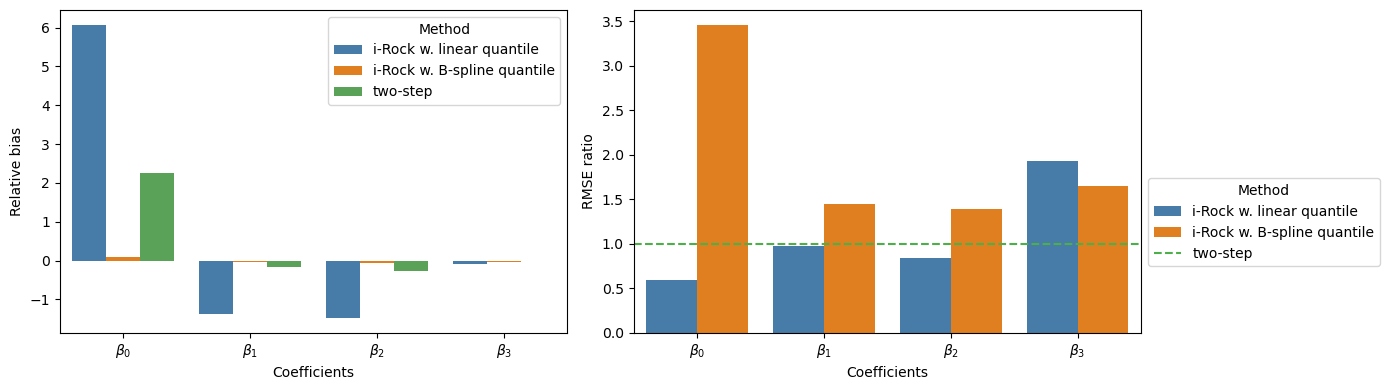

In [48]:
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1,2,1)
custom_colors = {
    'i-Rock w. linear quantile': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),   
    'i-Rock w. B-spline quantile': (1.0, 0.4980392156862745, 0.0),  
    'two-step': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726) 
}
custom_order = ['i-Rock w. linear quantile', 'i-Rock w. B-spline quantile','two-step']
sns.barplot(data=bias_std, x='variable', y='value', hue='Method', palette=custom_colors, hue_order=custom_order)
# Add labels and a legend
plt.xlabel('Coefficients')
plt.ylabel('Relative bias')
plt.legend(title='Method',loc="upper right")

ax = fig.add_subplot(1,2,2)
custom_colors = {
    'i-Rock w. linear quantile': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),   
    'i-Rock w. B-spline quantile': (1.0, 0.4980392156862745, 0.0)
}
custom_order = ['i-Rock w. linear quantile', 'i-Rock w. B-spline quantile']
sns.barplot(data=RMSE_long, x='variable', y='value', hue='Method',palette=custom_colors, hue_order=custom_order)
ax.axhline(y=1, color=(0.30196078431372547, 0.6862745098039216, 0.2901960784313726), linestyle='--',label='two-step')
# Add labels and a legend
plt.xlabel('Coefficients')
plt.ylabel('RMSE ratio')
#plt.legend(title='Method',bbox_to_anchor = (1, 0.5))
handles, labels = ax.get_legend_handles_labels()
new_order = [1, 2, 0]  # Assuming 'two-step' is the second entry
ax.legend([handles[i] for i in new_order], [labels[i] for i in new_order], title='Method', bbox_to_anchor=(1, 0.5))
#ax.legend(title='Method', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.savefig("3dim_nl_sqrtn_logn_5000.pdf", format="pdf")

In [29]:
n = 5000
data_global = data[(data["Method"]=="mRock_kNN_global_bs_Neyman") & (data["K"]==602)]
#data_global = data_global[data_global["seed"]<501]
beta0 = data_global["beta0"]/(22.24/np.sqrt(n))
beta1 = data_global["beta1"]/(42.8/np.sqrt(n))
beta2 = data_global["beta2"]/(19.26/np.sqrt(n))
beta3 = data_global["beta3"]/(19.26/np.sqrt(n))

#loc, scale = 0, 1
loc, scale = np.mean(beta0), np.std(beta0, ddof=1)
cdf0 = stats.norm(loc, scale).cdf
print(stats.ks_1samp(beta0, cdf0))
loc, scale = np.mean(beta1), np.std(beta1, ddof=1)
cdf1 = stats.norm(loc, scale).cdf
print(stats.ks_1samp(beta1, cdf1))
loc, scale = np.mean(beta2), np.std(beta2, ddof=1)
cdf2 = stats.norm(loc, scale).cdf
print(stats.ks_1samp(beta2, cdf2))
loc, scale = np.mean(beta3), np.std(beta3, ddof=1)
cdf3 = stats.norm(loc, scale).cdf
print(stats.ks_1samp(beta3, cdf3))

KstestResult(statistic=0.035877784843681426, pvalue=0.5286302922344897, statistic_location=2.123229937769597, statistic_sign=1)
KstestResult(statistic=0.030037734573300057, pvalue=0.7459425552972744, statistic_location=-2.066130756401285, statistic_sign=1)
KstestResult(statistic=0.026669908121247976, pvalue=0.8594764122531868, statistic_location=-4.359753442255526, statistic_sign=1)
KstestResult(statistic=0.026878091135473375, pvalue=0.8531598940278897, statistic_location=-12.693368919364032, statistic_sign=1)


# 2 dim

In [44]:
data = pd.read_csv("results_2d_final.csv")
data_group = data.drop(columns=["seed","p","tau"]).groupby(["Method","n"])
bias = data_group.mean()
#bias = math.sqrt(n)*data_group.apply(lambda x:(abs(x)).mean())
std = data_group.std()
RMSE = np.sqrt(data_group.apply(lambda x: (x**2).mean())).reset_index()

In [45]:
y1 = RMSE[RMSE["Method"]=="mRock"]
y2 = RMSE[RMSE["Method"]=="two_step_Neyman"]
table = np.divide(np.array(y2[["beta0","beta1","beta2"]]),np.array(y1[["beta0","beta1","beta2"]]))
table = pd.DataFrame(table,columns=["beta0","beta1","beta2"], index=[1000,2000,5000])
print(round(table,2).to_latex())

\begin{tabular}{lrrr}
\toprule
 & beta0 & beta1 & beta2 \\
\midrule
1000 & 7.190000 & 7.180000 & 1.610000 \\
2000 & 9.230000 & 7.690000 & 1.500000 \\
5000 & 10.410000 & 8.640000 & 1.630000 \\
\bottomrule
\end{tabular}

